# Data Visualization

1.​ Visualize the spatial distribution of key datasets using geopandas and matplotlib (or other tools if you want):

○​ Plot groundwater sources ('ergw1000_gwerg__v11_poly.csv') and overlay mining areas
('ergw1000_bergbaugebiete__v1_poly.csv').

○​ Create a choropleth map highlighting the distribution of different rock types ('ergw1000_gwerg_gestein_v1_poly.csv').

○​ Generate a histogram of groundwater extraction rates ('entn_bru') across different geological formations.

2.​ Provide insights based on the visualizations:

○​ Are there significant overlaps between important groundwater sources and mining areas?

○​ Which geological formations are most common in high-extraction regions?
 


unique datasets: 
-   bergbaugebiete_v1_poly
-   gwerg_erg_v11_poly
-   gwerg_gestein_v1_poly
-   gwerg__v11_poly
-   uferfiltrat_v1_poly
-   uferfiltrat_v1_line

In [ ]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import os
import pandas as pd
from pyhere import here
import seaborn as sns


In [2]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
# for plotting, transform to geographical crs 
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        gdf = gdf.to_crs(epsg=4326)
        #save to dict
        gdfs[filename] = gdf


### ​Groundwater sources and mining areas 

In [89]:
# mining data: add id to identify mining regions
mining_gdf = gdfs['bergbaugebiete__v1_poly'].reset_index(names='mining_id')
# groundwater data: filter only for "Bedeutende Grundwasservorkommen" (relevant groundwater storage), corresponding to 'erg_id' 11,12,13
water_gdf = gdfs['gwerg_erg_v11_poly']
water_gdf= water_gdf[water_gdf["erg_id"].isin([11,12,13])]

/tmp/ipykernel_64387/3334411437.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


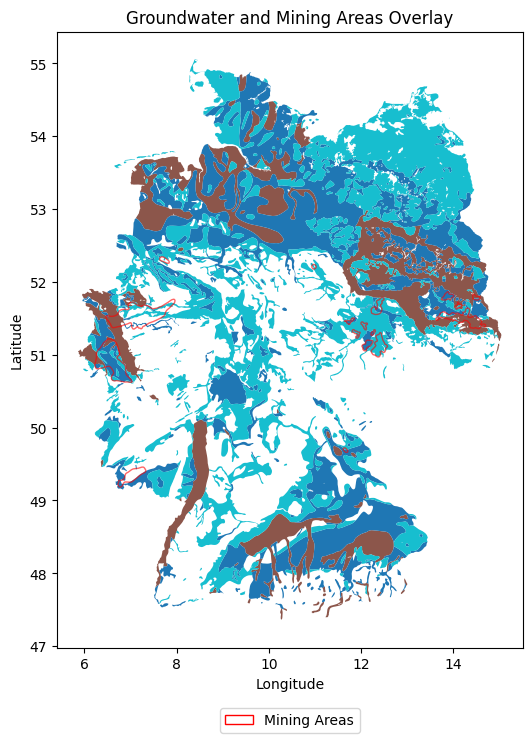

In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

# Plot groundwater areas with legend
water_gdf.plot(ax=ax, column="ergiebigke", legend=True)

# Overlay mining areas with outline only (no fill)
mining_gdf.plot(ax=ax, facecolor="none", edgecolor="red", alpha=0.6, label="Mining Areas")

plt.title("Groundwater and Mining Areas Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Manually create a patch for mining areas (just an outline)
mining_patch = mpatches.Patch(edgecolor="red", facecolor="none", label="Mining Areas")

# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Add mining area patch
handles.append(mining_patch)
labels.append("Mining Areas")

# Set updated legend
ax.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

plt.show()


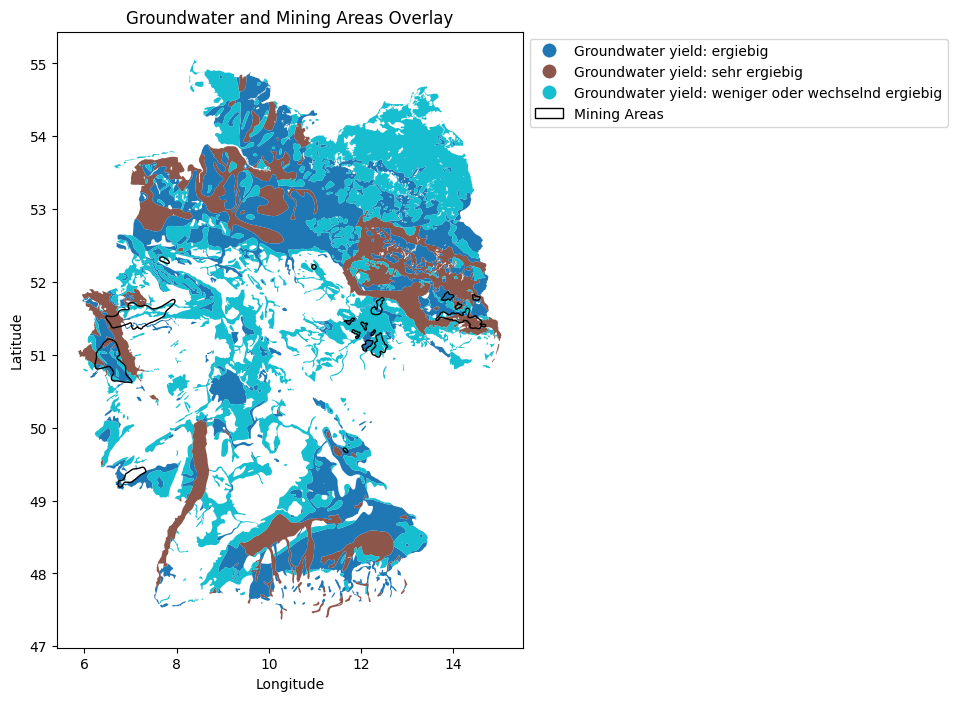

In [106]:

fig, ax = plt.subplots(figsize=(10, 8))

# Manually create colormap
unique_categories = water_gdf['erg_id'].unique()
cmap = plt.get_cmap('Blues')
# norm = plt.Normalize(vmin=8, vmax=water_gdf['erg_id'].max())

# Plot groundwater areas with the color map

water_gdf.plot(ax=ax, column='ergiebigke', legend=True)

# Overlay mining areas
mining_gdf.plot(ax=ax, facecolor="none", edgecolor="black", label="Mining Areas", legend=True)

plt.title("Groundwater and Mining Areas Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


# Get existing legend from groundwater plot
legend = ax.get_legend()

# Manually add mining areas to the legend
mining_patch = mpatches.Patch(edgecolor='black', facecolor='none', label="Mining Areas")

# Create new legend with both groundwater and mining areas
handles, labels = legend.legend_handles, [t.get_text() for t in legend.texts]
labels = [f"Groundwater yield: {value}" for value in labels]
handles.append(mining_patch)
labels.append("Mining Areas")

ax.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=True)

plt.savefig(here("plots/groundwater_mining_areas.png"), dpi=300, bbox_inches="tight")
plt.show()




### ​Choropleth map for rock types

In [5]:
geo_gdf = gdfs['gwerg_gestein_v1_poly']
# remove missing rocktype (gestein) information
geo_gdf = geo_gdf.dropna() 

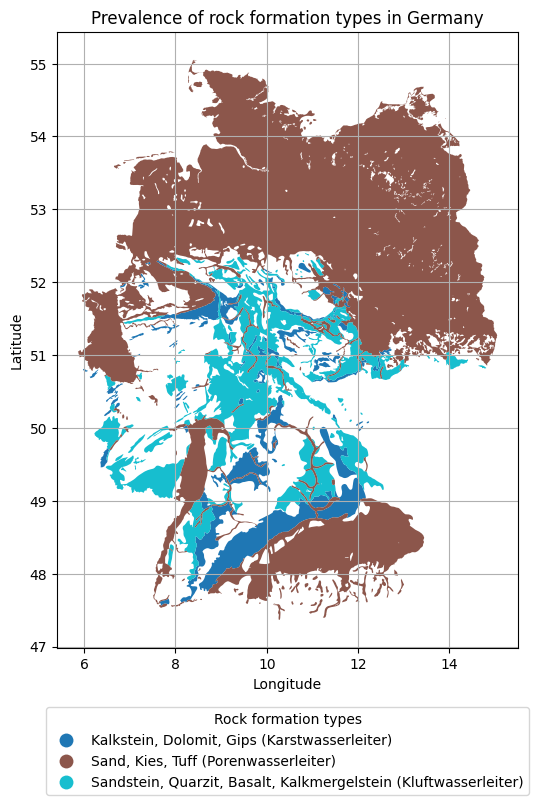

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

geo_gdf.plot(ax = ax,
             column = 'gestein', 
             legend=True, 
             legend_kwds={"loc": "lower center", 
                          "bbox_to_anchor": (0.5, -0.25), 
                          "title": "Rock formation types", 
                          
                          }
                          )
plt.title("Prevalence of rock formation types in Germany")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.savefig(here("plots/rock_formation_types.png"), dpi=300, bbox_inches="tight")
plt.show()

### ​ Generate a histogram of groundwater extraction rates

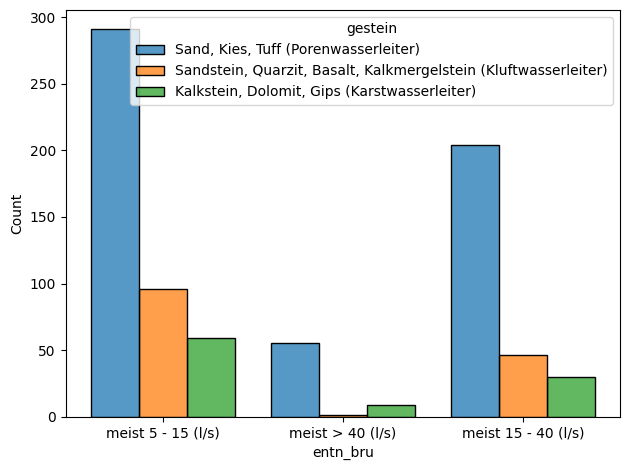

In [ ]:
sns.histplot(water_gdf, x='entn_bru', hue= 'gestein', multiple = 'dodge', shrink=0.8)
plt.tight_layout()

In [8]:

('entn_bru') across different geological formations.

SyntaxError: invalid syntax (1811369957.py, line 1)